#### **Linear Regression**
###### **In this tutorial we will deal with a regression problem and we will learn how to load the data, analyze the data and apply some pre-processing and apply a linear regression model(having only one layer). And further this tutorial we will extend this to a deep neural network. This will help us deep understanding of keras dense layer and activation functions.**

#### **Let's Start**

**Import Necessary Libraries**

In [1]:
# To Silence Warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import Libraries
import pandas as pd     # used to work with datasets, analyze and modify them
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

**Load Dataset**

In [9]:
dataset = pd.read_csv('data.csv')
dataset.head(10)

,Std_Id,Attendance,Class_Test,Mid,Final,Type
0,LR01,8,8,20,40,Regular
1,LR02,9,7,19,32,Re_Admit
2,LR03,9,9,26,27,Re_Admit
3,LR04,5,8,27,42,Regular
4,LR05,7,5,24,37,Regular
5,LR06,8,5,19,38,Regular
6,LR07,8,5,20,40,Regular
7,LR08,5,9,19,33,Regular
8,LR09,7,10,27,30,Regular
9,LR10,7,8,22,39,Regular


**Clean Data**

In [12]:
# Drop the data with missing values. In our dataset there is no missing value, so we need not drop anything.
#dataset = dataset.dropna()
#dataset

# Convert Categorical 'Type' data into one-hot data: In our dataset, all the data are numerical except Type data. So, to ignore confusion of our model we will one-hot encoding the type.
dataset = pd.read_csv('data.csv')
type = dataset.pop('Type')
dataset['Regular'] = (type == 'Regular')*1
dataset['Re_Admit'] = (type == 'Re_Admit')*1
print(dataset)

**Split Data into Train-Test**

In [32]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(dataset.shape, train_dataset.shape, test_dataset.shape)
train_dataset.describe().transpose()

(100, 7) (80, 7) (20, 7)


,count,mean,std,min,25%,50%,75%,max
Attendance,80.0,7.2000,1.335020,5.0,7.0,7.0,8.0,10.0
Class_Test,80.0,7.4625,1.749819,5.0,5.0,8.0,9.0,10.0
Mid,80.0,22.1625,3.183994,19.0,19.0,20.0,26.0,27.0
Final,80.0,35.8250,4.716722,27.0,32.0,37.0,40.0,44.0
Regular,80.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0
Re_Admit,80.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0


###### **In our dataset, we have 10 entries and 7 different columns. From which 8 entries will be used for training and remaining 2 entries will be used for testing. And the dercribe function gives us some parameters that might be used to analyze the dataset.**

**Split Features**
###### **Here, we will split the features from the labels. From our dataset, we will predict *Final* marks so we copy the training and testing dataset as training and testing features and because Final is the label of both training and testing features we pop the *Final* label.**

In [33]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Final')
test_labels = test_features.pop('Final')

**Plot Features**
###### **We will define a simple plot function and can use the function to plot any feature.**

In [34]:
def plot(feature, x=None, y=None):
    plt.figure(figsize=(10,5))
    plt.scatter(train_features[feature], train_labels, label='Data')
    if(x is not None and y is not None):
        plt,plot(x, y, color='k', label='Prediction')
    plt.xlabel(feature)
    plt.ylabel('Final')
    plt.legend()

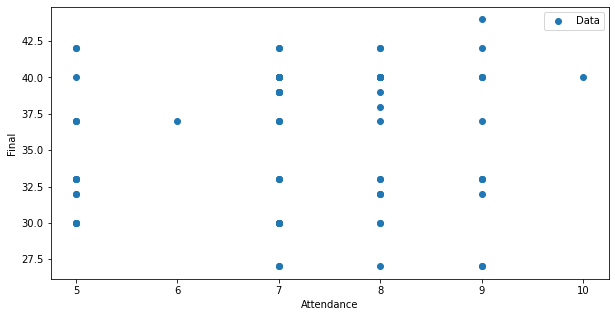

In [36]:
plot('Attendance')

**Normalize**
###### **If we see the description of the data, seen above in Split Data in Train-Test, we can see that the mean values have different ranges. If we take then as it is, it may confuge our model. The best way to overcome it is to normalize the data. For this, we can use a normalization layer from tensorflow preprocessing module.**

In [38]:
# First, see the data
print(train_dataset.describe().transpose()[['mean', 'std']])

# Normalization
normalizer = preprocessing.Normalization()  # This is a keras layer for sequential api.
# Adapt to Data: To call the normalizer we have to adapt it to our data.
# Because our dataset is a pandas dataset, we need to make it to a numpy array.
normalizer.adapt(np.array(train_features))

               mean       std
Attendance   7.2000  1.335020
Class_Test   7.4625  1.749819
Mid         22.1625  3.183994
Final       35.8250  4.716722
Regular      0.0000  0.000000
Re_Admit     0.0000  0.000000


###### **Let's check out the first training features to be normalized. When the normalize layer is called, it returns the input data with each feature independently normalized. It uses the formula- ((input-mean)/stddev).**

In [39]:
first = np.array(train_features[:1])
normalized_first = normalizer(first).numpy()

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).